In [1]:
!pip install scikit-learn xgboost lightgbm transformers torch seaborn wordcloud

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 39.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 57.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 47.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 16.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 61.3 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [2]:
import tensorflow as tf

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("GPU memory growth set!")
    except RuntimeError as e:
        print(e)

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, accuracy_score

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
import xgboost as xgb
import lightgbm as lgb

from sklearn.feature_extraction.text import TfidfVectorizer

import warnings
warnings.filterwarnings('ignore')

In [4]:
df = pd.read_csv('/content/combined_featured_dataset.csv')
df.head()

,Message,label,Clean_Message,source,has_html,link_count,entropy,urgency_score,has_urgency_keyword,emotion_density,char_count,word_count,log_char_count,log_word_count,avg_word_len
0,\n\nStart Date: 10/13/01; HourAhead hour: 22; ...,0,start date: 10/13/01 hourahead hour: 22 ancill...,benign,0,0,4.432831,0.0,0,0.012500,638,80,6.459904,4.394449,7.975000
1,---------------------- Forwarded by Vince J Ka...,0,forwarded vince kaminski/hou/ect 03/27/2000 20...,benign,1,10,4.381544,17.5,1,0.008178,5895,856,8.682029,6.753438,6.886682
2,\n [IMAGE] Webcast June 14th @ 2:00...,0,image webcast june 14th @ 2:00pm edt click reg...,benign,0,2,4.278517,4.5,1,0.005917,1195,169,7.086738,5.135798,7.071006
3,\n\n -----Original Message-----\nFrom: =09Dupo...,0,original message from: 09dupont anita 20 sent:...,benign,0,0,4.291279,2.5,1,0.001122,5536,891,8.619208,6.793466,6.213244
4,"Jeff--please change my name to ""mike d. smith""...",0,jeffplease change name mike smith thanks forwa...,benign,0,0,4.383765,0.5,1,0.000000,2557,464,7.846981,6.142037,5.510776


In [5]:
df['label'].value_counts(normalize=True)

,proportion
label,
0,0.919472
1,0.080528


In [6]:
engineered_features = [
    'has_html', 'link_count', 'entropy', 'urgency_score',
    'emotion_density', 'char_count', 'word_count', 'avg_word_len'
]

X_struct = df[engineered_features]
y = df['label']

In [7]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(max_features=5000, ngram_range=(1,2), stop_words='english')
X_tfidf = tfidf.fit_transform(df['Clean_Message'].fillna(''))

In [8]:
from scipy.sparse import hstack

X_combined = hstack([X_tfidf, X_struct])

In [9]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_combined, y, test_size=0.1, stratify=y, random_state=42
)

print(X_train.shape, X_test.shape)

(111717, 5008) (12413, 5008)


In [10]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay, roc_curve

lr_model = LogisticRegression(max_iter=500, random_state=42)

lr_model.fit(X_train, y_train)

y_pred_lr = lr_model.predict(X_test)
y_proba_lr = lr_model.predict_proba(X_test)[:, 1]

In [11]:
print("Classification Report (Logistic Regression):\n")
print(classification_report(y_test, y_pred_lr, digits=4))

Classification Report (Logistic Regression):

              precision    recall  f1-score   support

           0     0.9906    0.9982    0.9944     11413
           1     0.9781    0.8920    0.9331      1000

    accuracy                         0.9897     12413
   macro avg     0.9843    0.9451    0.9637     12413
weighted avg     0.9896    0.9897    0.9895     12413



In [12]:
auc_lr = roc_auc_score(y_test, y_proba_lr)
print("AUC Score (Logistic Regression): {:.4f}".format(auc_lr))

AUC Score (Logistic Regression): 0.9986


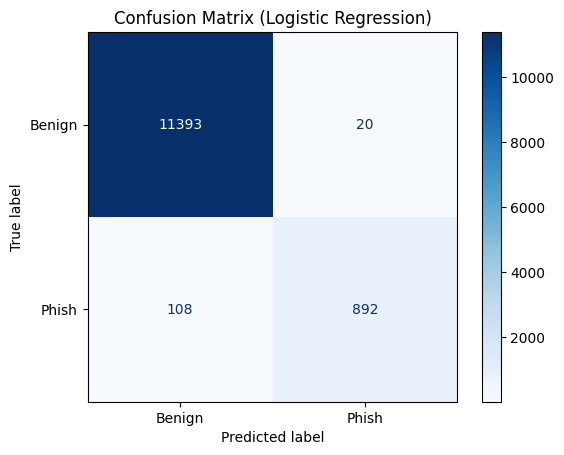

In [13]:
cm = confusion_matrix(y_test, y_pred_lr)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Benign', 'Phish'])
disp.plot(cmap='Blues')
plt.title("Confusion Matrix (Logistic Regression)")
plt.show()

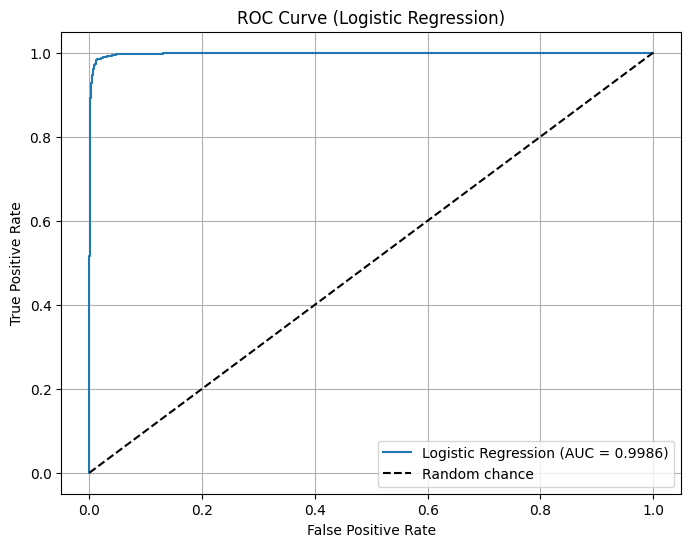

In [14]:
fpr, tpr, thresholds = roc_curve(y_test, y_proba_lr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'Logistic Regression (AUC = {auc_lr:.4f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random chance')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (Logistic Regression)')
plt.legend()
plt.grid()
plt.show()

In [15]:
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(
    n_estimators=100,
    random_state=42,
    n_jobs=-1,
    class_weight='balanced'
)

# Train on training set
rf_model.fit(X_train, y_train)

# Predict
y_pred_rf = rf_model.predict(X_test)
y_proba_rf = rf_model.predict_proba(X_test)[:, 1]

In [16]:
print("Classification Report (Random Forest):\n")
print(classification_report(y_test, y_pred_rf, digits=4))

Classification Report (Random Forest):

              precision    recall  f1-score   support

           0     0.9920    0.9996    0.9958     11413
           1     0.9956    0.9080    0.9498      1000

    accuracy                         0.9923     12413
   macro avg     0.9938    0.9538    0.9728     12413
weighted avg     0.9923    0.9923    0.9921     12413



In [17]:
auc_rf = roc_auc_score(y_test, y_proba_rf)
print("AUC Score (Random Forest): {:.4f}".format(auc_rf))

AUC Score (Random Forest): 0.9983


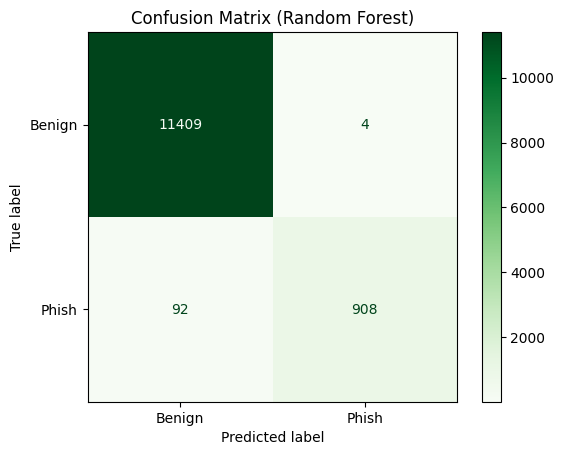

In [18]:
cm = confusion_matrix(y_test, y_pred_rf)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Benign', 'Phish'])
disp.plot(cmap='Greens')
plt.title("Confusion Matrix (Random Forest)")
plt.show()

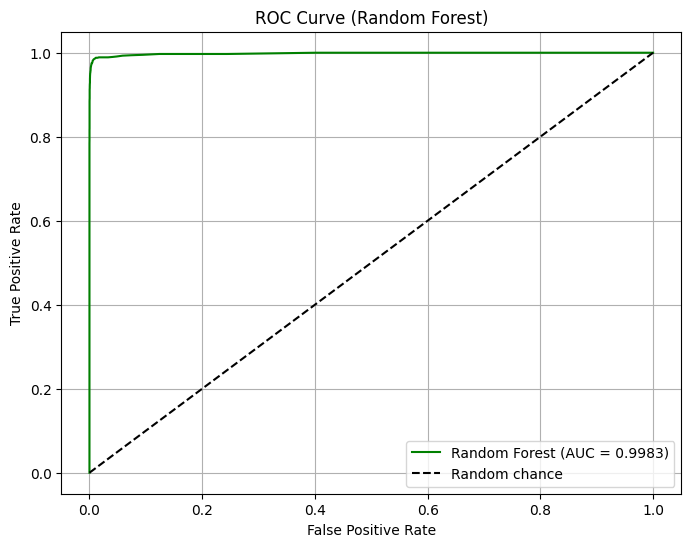

In [19]:
fpr, tpr, thresholds = roc_curve(y_test, y_proba_rf)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'Random Forest (AUC = {auc_rf:.4f})', color='green')
plt.plot([0, 1], [0, 1], 'k--', label='Random chance')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (Random Forest)')
plt.legend()
plt.grid()
plt.show()

For SVM we will only use TF-IDF features, not combined features (TF-IDF + structured), because SVM does not easily handle sparse + dense matrix concatenation directly.

In [20]:
from sklearn.model_selection import train_test_split


X_train_tfidf, X_test_tfidf, y_train_tfidf, y_test_tfidf = train_test_split(
    X_tfidf, y, test_size=0.1, stratify=y, random_state=42
)

In [21]:
from sklearn.svm import SVC

svm_model = SVC(kernel='linear', probability=True, random_state=42)

svm_model.fit(X_train_tfidf, y_train_tfidf)

y_pred_svm = svm_model.predict(X_test_tfidf)
y_proba_svm = svm_model.predict_proba(X_test_tfidf)[:, 1]

In [22]:
print("Classification Report (SVM):\n")
print(classification_report(y_test_tfidf, y_pred_svm, digits=4))

Classification Report (SVM):

              precision    recall  f1-score   support

           0     0.9939    0.9970    0.9955     11413
           1     0.9647    0.9300    0.9470      1000

    accuracy                         0.9916     12413
   macro avg     0.9793    0.9635    0.9712     12413
weighted avg     0.9915    0.9916    0.9916     12413



In [23]:
auc_svm = roc_auc_score(y_test_tfidf, y_proba_svm)
print("AUC Score (SVM): {:.4f}".format(auc_svm))

AUC Score (SVM): 0.9978


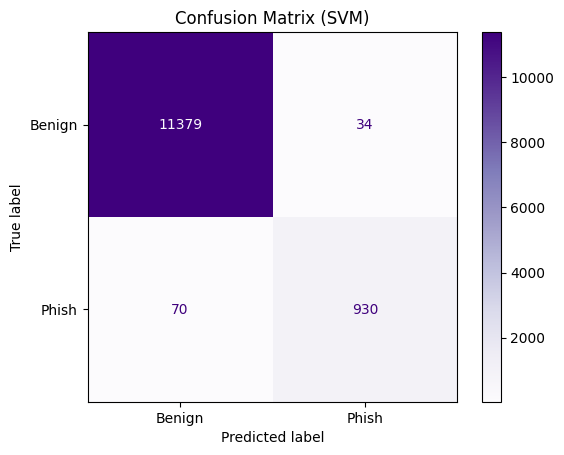

In [24]:
cm = confusion_matrix(y_test_tfidf, y_pred_svm)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Benign', 'Phish'])
disp.plot(cmap='Purples')
plt.title("Confusion Matrix (SVM)")
plt.show()

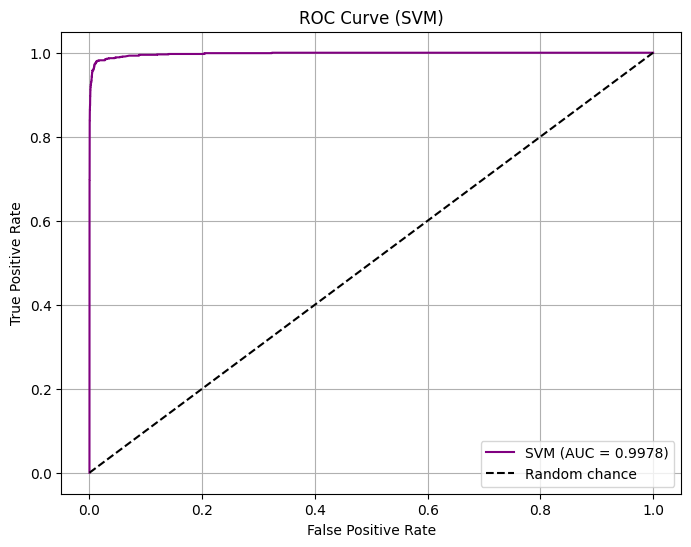

In [25]:
fpr, tpr, thresholds = roc_curve(y_test_tfidf, y_proba_svm)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'SVM (AUC = {auc_svm:.4f})', color='purple')
plt.plot([0, 1], [0, 1], 'k--', label='Random chance')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (SVM)')
plt.legend()
plt.grid()
plt.show()

In [26]:
import xgboost as xgb


xgb_model = xgb.XGBClassifier(
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42,
    n_jobs=-1,
    scale_pos_weight=(len(y_train) - sum(y_train)) / sum(y_train)
)


xgb_model.fit(X_train, y_train)


y_pred_xgb = xgb_model.predict(X_test)
y_proba_xgb = xgb_model.predict_proba(X_test)[:, 1]

In [27]:
print("Classification Report (XGBoost):\n")
print(classification_report(y_test, y_pred_xgb, digits=4))

Classification Report (XGBoost):

              precision    recall  f1-score   support

           0     0.9979    0.9954    0.9967     11413
           1     0.9494    0.9760    0.9625      1000

    accuracy                         0.9939     12413
   macro avg     0.9737    0.9857    0.9796     12413
weighted avg     0.9940    0.9939    0.9939     12413



In [28]:
auc_xgb = roc_auc_score(y_test, y_proba_xgb)
print("AUC Score (XGBoost): {:.4f}".format(auc_xgb))

AUC Score (XGBoost): 0.9993


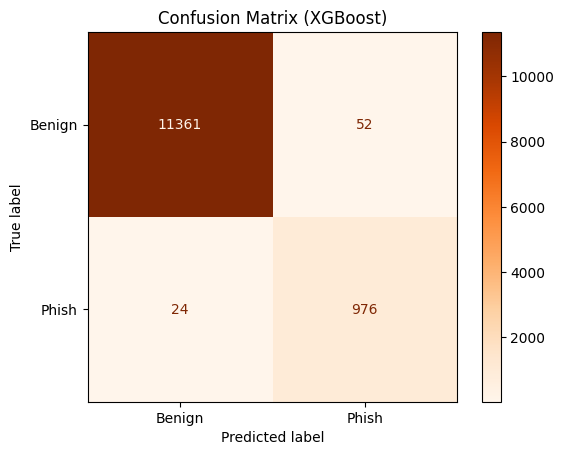

In [29]:
cm = confusion_matrix(y_test, y_pred_xgb)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Benign', 'Phish'])
disp.plot(cmap='Oranges')
plt.title("Confusion Matrix (XGBoost)")
plt.show()

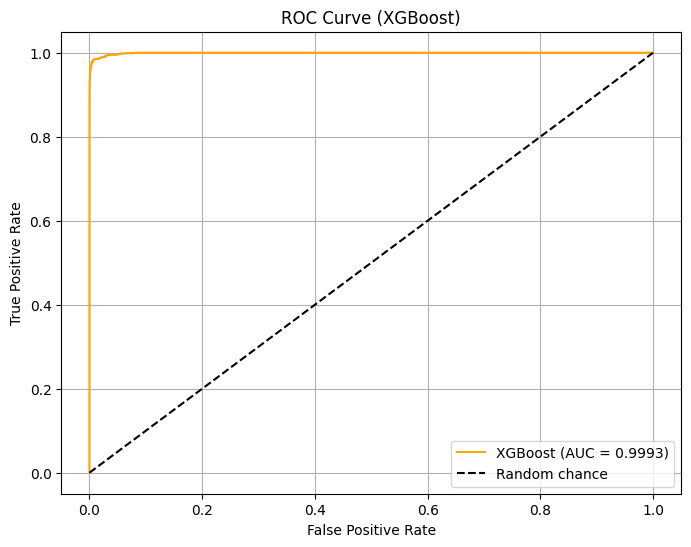

In [30]:
fpr, tpr, thresholds = roc_curve(y_test, y_proba_xgb)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'XGBoost (AUC = {auc_xgb:.4f})', color='orange')
plt.plot([0, 1], [0, 1], 'k--', label='Random chance')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (XGBoost)')
plt.legend()
plt.grid()
plt.show()

In [31]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

lr_acc = accuracy_score(y_test, y_pred_lr)
lr_prec = precision_score(y_test, y_pred_lr)
lr_rec = recall_score(y_test, y_pred_lr)
lr_f1 = f1_score(y_test, y_pred_lr)
lr_auc = roc_auc_score(y_test, y_proba_lr)

rf_acc = accuracy_score(y_test, y_pred_rf)
rf_prec = precision_score(y_test, y_pred_rf)
rf_rec = recall_score(y_test, y_pred_rf)
rf_f1 = f1_score(y_test, y_pred_rf)
rf_auc = roc_auc_score(y_test, y_proba_rf)

svm_acc = accuracy_score(y_test_tfidf, y_pred_svm)
svm_prec = precision_score(y_test_tfidf, y_pred_svm)
svm_rec = recall_score(y_test_tfidf, y_pred_svm)
svm_f1 = f1_score(y_test_tfidf, y_pred_svm)
svm_auc = roc_auc_score(y_test_tfidf, y_proba_svm)

xgb_acc = accuracy_score(y_test, y_pred_xgb)
xgb_prec = precision_score(y_test, y_pred_xgb)
xgb_rec = recall_score(y_test, y_pred_xgb)
xgb_f1 = f1_score(y_test, y_pred_xgb)
xgb_auc = roc_auc_score(y_test, y_proba_xgb)

In [32]:
data_ml = {
    "Model": ["Logistic Regression", "Random Forest", "SVM", "XGBoost"],
    "Accuracy": [lr_acc, rf_acc, svm_acc, xgb_acc],
    "Precision": [lr_prec, rf_prec, svm_prec, xgb_prec],
    "Recall": [lr_rec, rf_rec, svm_rec, xgb_rec],
    "F1-score": [lr_f1, rf_f1, svm_f1, xgb_f1],
    "AUC": [lr_auc, rf_auc, svm_auc, xgb_auc]
}

df_ml_metrics = pd.DataFrame(data_ml)

In [33]:
df_ml_metrics = df_ml_metrics.round(4)
df_ml_metrics

,Model,Accuracy,Precision,Recall,F1-score,AUC
0,Logistic Regression,0.9897,0.9781,0.892,0.9331,0.9986
1,Random Forest,0.9923,0.9956,0.908,0.9498,0.9983
2,SVM,0.9916,0.9647,0.930,0.9470,0.9978
3,XGBoost,0.9939,0.9494,0.976,0.9625,0.9993
